# Evaluating Dynamic Sea Level along the Dutch coast in an Earth System Model

Code of Capstone (bachelor thesis) Marit Verbeek, June 1st 2022.

In this main notebook, I create the results for our first location along the Dutch coast, Den Helder. For the evaluation, I use tide gauge observations and the DSL data from EC-Earth3P.

### Importing packages

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scipy
from scipy import signal
import matplotlib
rng = np.random.default_rng()
import cartopy.crs as ccrs

### Reading data

First, we open de model data and tide gauge observations and convert them to xarray. 

In [2]:
# First we open the downloaded EC-Earth3p model data
df = xr.open_dataarray('../data/zos_denhelder/zos_DenHelder.nc') 

# Then we open the tide gauge data and turn it into a useful format
dtg = pd.read_csv('../data/tidegauge_psmsl/23.rlrdata.txt', #23 is Den Helder
                 sep=';', usecols=[1], 
                 names=['level'])  

# Now we define dates and months for the period used
dates = pd.date_range(start='1865-01-01', end='2021-01-01', 
                      freq='M') 

# And we add dates to the data so we can create nice time series
dtg['time'] = dates 
dtg = dtg.set_index('time')

In [3]:
# We will have a look at the model data and the components:
df

<xarray.DataArray (time: 1812, src: 2, exp: 2, member: 3)>
array([[[[-0.383607, ..., -0.128381],
         [-0.280609, ..., -0.384627]],

        [[-0.204909, ..., -0.245206],
         [-0.226851, ...,  0.056227]]],


       ...,


       [[[      nan, ...,       nan],
         [      nan, ...,       nan]],

        [[      nan, ...,       nan],
         [      nan, ...,       nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * src      (src) object 'EC-Earth3P' 'EC-Earth3P-HR'
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'

In [4]:
# And the tide gauge:
dtg

level
time             
1865-01-31   6814
1865-02-28   6589
1865-03-31   6519
1865-04-30   6529
1865-05-31   6679
...           ...
2020-08-31   7037
2020-09-30   7023
2020-10-31   7066
2020-11-30   7078
2020-12-31   7032

[1872 rows x 1 columns]

### The time series

#### Model zos

First, we plot the model data for the location. EC-Earth3p
uses two configurations, the HR with an eddy-permitting ocean (0.25° grid spacing in the ocean) and the SR
with a non-eddying ocean (1° ocean grid spacing). For this paper, we will use local data of a point closest to
the observational data we have. I will start with a single location, which is Den Helder. I imported ’zos’ data
for the DSL. I will also detrend the data below and show the average of all ensemble members, to create one nice figure with two subplots for a good overview.

Text(0.84, 0.98, 'end-century')

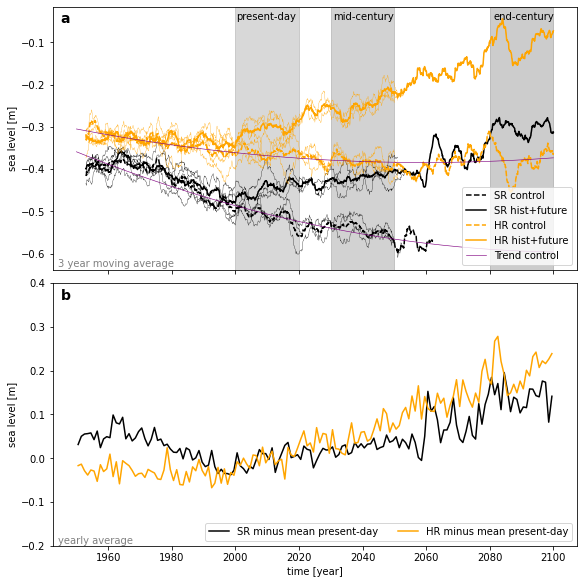

In [5]:
f, ax = plt.subplots(2,1, figsize=(8,8), sharex=True, constrained_layout=True)
f.align_ylabels()

# In the first figure we plot all model data; SR and HR control and hist+future over the whole time series for the three members:
for i, Src in enumerate(df.src.values): # Src is SR and HR    
    for j, Exp in enumerate(df.exp.values): # Exp are the two simulations      
        timevalues = df.time.dt.year + df.time.dt.month/12 # We want the means per year
        # Now, we create the actual plot for this using a three year rolling average to make it clearer:
        # First plot the time series for the average of all members:
        ax[0].plot(timevalues, df.mean('member').sel({'exp':Exp, 'src':Src}).rolling(time=36).mean(), 
                   label=f'{["SR","HR"][i]} {Exp}', color=['black','orange'][i], ls=['--','-'][j])
       
        # Then all the ensemble members seperately, too:
        for mem in df.member.values:
            ax[0].plot(timevalues, df.sel({'member':mem, 'exp':Exp, 'src':Src}).rolling(time=36).mean(),
                       color=['black','orange'][i], lw=.3)
            
# Then, we also want to show the trends in the control run:
dc =df.mean('member').sel(exp='control').sel(src='EC-Earth3P').groupby(df.time.dt.year).mean()
# Then we do the second degree fitting for the control run:
fit1 = dc.polyfit(dim='year', deg=2).polyfit_coefficients 
# So then below is the curve for the trend in the control run:
ts1 = dc.year**2*fit1[0] + dc.year*fit1[1]+fit1[2] 
ax[0].plot(ts1.year, ts1, label = f'Trend control', color='purple', lw=0.6)

# Then we do exactly the same for HR:
dch=df.mean('member').sel(exp='control').sel(src='EC-Earth3P-HR').groupby(df.time.dt.year).mean()
fit2 = dch.polyfit(dim='year', deg=2).polyfit_coefficients 
ts2 = dch.year**2*fit2[0] + dch.year*fit2[1]+fit2[2] 
ax[0].plot(ts2.year, ts2, color='purple', lw=0.6)


# In b), ([ax]1) we will plot the hist+future for the mean of the members, minus the mean of present-day:

# First, we select the mean of the members and the correct simulation:
hf = df.sel(exp='hist+future').mean('member')

# Then we create the present-day mean to subtract that from the runs, once for SR and once for HR:
presentday = hf.sel(time=slice('2000-01-31', '2020-12-31'))

#SR:
psds = presentday.sel(src='EC-Earth3P')
hists = hf.sel(src='EC-Earth3P') - psds.mean() 
ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), hists.groupby(hists.time.dt.year).mean(), 
            label=f'SR minus mean present-day', color='black')

#HR:
psdh = presentday.sel(src='EC-Earth3P-HR')
histh = hf.sel(src='EC-Earth3P-HR') - psdh.mean()
ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), histh.groupby(histh.time.dt.year).mean(), 
            label=f'HR minus mean present-day', color='orange')


# Then we set the layout for the figures:
ax[0].set_ylabel('sea level [m]')
ax[0].legend(ncol=1, loc=4)
ax[0].text(.01,.01, '3 year moving average', color='grey', transform=ax[0].transAxes)
ax[0].text(.015,.98, 'a', transform=ax[0].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')  
ax[1].set_ylabel('sea level [m]')
ax[1].set_ylim((-0.2, 0.4))
ax[1].set_xlabel('time [year]')
ax[1].text(.01,.01, 'yearly average', color='grey', transform=ax[1].transAxes)
ax[1].legend(ncol=2, loc=4)
ax[1].text(.015,.98, 'b', transform=ax[1].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')

# Here we create three grey boxes to show the different time spans we will refer to further on:
ax[0].axvspan(2000,2020, color='grey', alpha=.3) 
ax[0].text(.35,.98, 'present-day', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2030,2050, color='grey', alpha=.35)
ax[0].text(.535,.98, 'mid-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2080,2100, color='grey', alpha=.4)
ax[0].text(.84,.98, 'end-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')

# Lastly, we save the figure:
#f.savefig('../results/modelseries.jpg', dpi=300, bbox_inches='tight')

#### Monthly means

Now, we want to plot the monthly mean DSL to get an insight in the extreme DSL events. For this, we also subtract the present-day mean to get the change with respect to contemporary DSL.

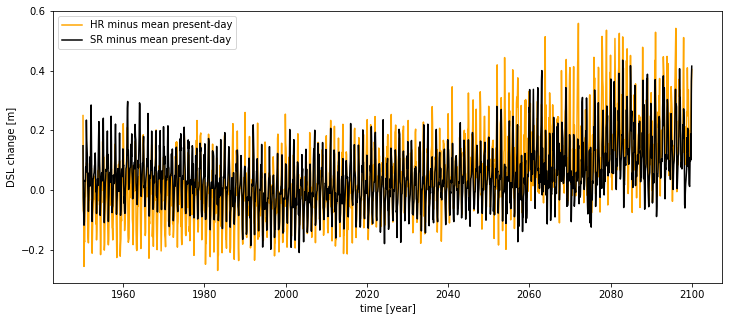

In [6]:
fig = plt.figure(figsize=(12,5))

# We use the 'histh' and 'hists' from the previous plot, 
# which are the member-mean historic and future simulations, minus the mean of 2000-2020.
# Then, we simply plot this as monthly means

plt.plot(df.time, histh, 
            label=f'HR minus mean present-day', color='orange')
plt.plot(df.time, hists, 
            label=f'SR minus mean present-day', color='black')

plt.ylabel('DSL change [m]')
plt.xlabel('time [year]')
plt.legend()
#fig.savefig('../results/extremes.jpg', dpi=300, bbox_inches='tight')

##### Tide gauge observations

Now, I will plot the time series of the downloaded tide gauge data. The data is monthly, but to make the plot less noisy, I will create twelve month rolling means.

Text(0, 0.5, 'sea level above NAP [m]')

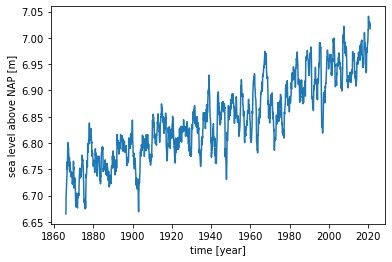

In [7]:
# I will turn the montlhy means into yearly averages and convert the level from milimeters to meters and plot the result
plt.plot(dtg.to_xarray().time.dt.year + dtg.to_xarray().time.dt.month/12, dtg.to_xarray().level.rolling(time=12).mean().values/1000) 

# Then setting the figure layout
plt.xlabel('time [year]')
plt.ylabel('sea level above NAP [m]')

#plt.savefig('../results/tgseries.jpg', dpi=300, bbox_inches='tight')

### Spectral analysis

Since the time series of the model are in DSL, but the tide gauge observations are RSL, we cannot compare them one-to-one. Therefore, we will conduct a spectral analysis to investigate the variability of the data. Before we can apply the analysis, we need to de-trend the TG and model data.

#### Preparing TG data

In [8]:
# Since the tide gauge data is in unix time until nanoseconds, 
#  we need to convert this to do the spectral analysis in monthly means:
tg = dtg.squeeze().to_xarray()
tg = tg/1000 # Here we turn the millimeter level into meters
dt64 = tg.time.values
unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
one_nsecond = np.timedelta64(1, 'ns')
unix_secs = (dt64 - unix_epoch)/one_second
unix_nsecs = (tg.time.values - unix_epoch)/one_nsecond

Text(0, 0.5, 'sea level above NAP [m]')

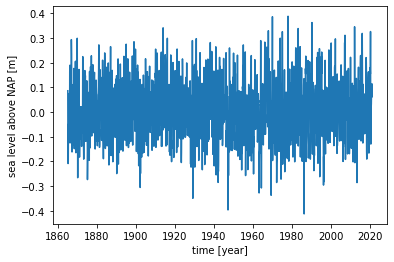

In [9]:
# Now, we want to de-trend the timeseries for a clean spectral analysis:
fit = tg.polyfit(dim='time', deg=1).polyfit_coefficients

# So then the time series of the fit will be:
ts = unix_nsecs*fit[0].values + fit[1].values

# Which we subtract from the original series to get the desired de-trending:
dgdt = tg-ts

# So finally, we plot the following:
plt.plot(tg.time, dgdt)

# Then setting the figure layout:
plt.xlabel('time [year]')
plt.ylabel('sea level above NAP [m]')

#### Preparing model data

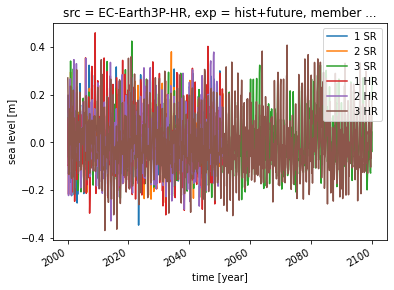

In [10]:
# Next, we de-trend the model time series
# First, we account for the model drift by subtracting the fit to the control run from the historic and future run:

dr_lst = []
for i, Src in enumerate(df.src.values): # Src is SR and HR

    for j, mem in enumerate(df.member.values): # mem are the ensemble members:
        dt = df.sel({'src':Src}).sel({'member':mem}).sel(time=slice('2000-01-31', '2100-12-31')) 
        dc = dt.sel(exp='control')
        unix_nsecs = (dc.time.values - unix_epoch)/one_nsecond
        
        # Now, we do the first fitting for the control run:
        fit1 = dc.polyfit(dim='time', deg=1).polyfit_coefficients
        
        # This gives the following trend we need to subtract from the hist+future run:
        ts = unix_nsecs*fit1[0].values + fit1[1].values
       
        dh = dt.sel(exp='hist+future')
        dhf = dh-ts
        
        # Then, we need to take out the trend that is in that time series for a good spectral analysis:
        fit3 = dhf.polyfit(dim='time', deg=1).polyfit_coefficients
        ts3 = unix_nsecs*fit3[0].values + fit3[1].values
        
        # So we will use the following time series for the spectral analysis:
        dr = dhf-ts3   
        dr_lst.append(dr)
        dr.plot(label=f'{["1","2", "3"][j]} {["SR", "HR"][i]}') 
        
plt.xlabel('time [year]')
plt.ylabel('sea level [m]')
plt.legend()

#### Welch's method ensemble members

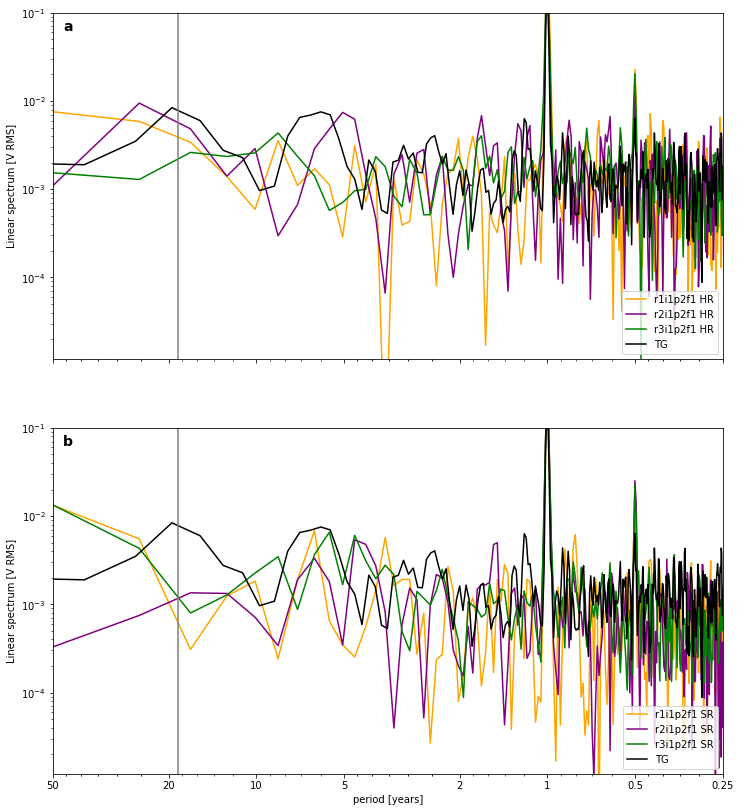

In [11]:
# Now, we can apply the actual Welch method to the de-trended time series we created. 
# We will create two panels; one for the SR ensemble members, and one for the HR:
f, ax = plt.subplots(2,1, figsize=(12,14), sharex=True)
f.align_ylabels()
ax[1].set_xlabel('period [years]')
# We add letters to the two panels:
ax[0].text(.015,.98, 'a', transform=ax[0].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')
ax[1].text(.015,.98, 'b', transform=ax[1].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')

# First, we create the ticks for the x-axis, for the variabilities we want to plot:
xticks = [50,20,10,5,2,1,.5,.25]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)

# Now, we can do the actual Welch analysis for all the single ensemble members (2 times 3):
s1, s1spec = signal.welch(dr_lst[0].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(s1, s1spec, label=f'r1i1p2f1 SR', color='orange')
s2, s2spec = signal.welch(dr_lst[1].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(s2, s2spec, label=f'r2i1p2f1 SR', color='purple')
s3, s3spec = signal.welch(dr_lst[2].sel()[:-2], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[1].plot(s3, s3spec, label=f'r3i1p2f1 SR', color='green')
h1, h1spec = signal.welch(dr_lst[3].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(h1, h1spec, label=f'r1i1p2f1 HR', color='orange')
h2, h2spec = signal.welch(dr_lst[4].sel()[:-606], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(h2, h2spec, label=f'r2i1p2f1 HR', color='purple')
h3, h3spec = signal.welch(dr_lst[5].sel()[:-2], fs=12, nperseg=606, detrend = False, return_onesided=True)
ax[0].plot(h3, h3spec, label=f'r3i1p2f1 HR', color='green')

# The following lay-out steps applie to both axes, so we will loop over them:
for i, x in enumerate([0, 1]):

    tgs, Pxx_spec = signal.welch(dgdt, fs=12, nperseg=2*468,  detrend = False, return_onesided=True)
    ax[i].plot(tgs, Pxx_spec, label='TG', color='black')    
    ax[i].set_xscale('log', base=10)
    ax[i].set_yscale('log', base=10)
    ax[i].set_xlim((1/50,1/24))
    ax[i].set_ylim((1.2e-5,1e-1))
    
    ax[i].set_ylabel('Linear spectrum [V RMS]')
    ax[i].axvline(1/18.6, c='C7')
    ax[i].xaxis.set_minor_locator(locmin)
    ax[i].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax[i].set_xticks([1/x for x in xticks])
    ax[i].set_xticklabels(xticks)
    ax[i].legend(ncol=1, loc=4)

#plt.savefig('../results/welch.jpg', dpi=300, bbox_inches='tight')

#### Member means

For an easier analysis of the results above, we will take the mean of the ensemble members per resolution. Also, we will show the weighted means of the frequency intensities on three periods: sub-annual (0.25-1 year), interannual (1-9 years) and multi-decadal (10-50 years).

In [12]:
#FIrst, we define a function to calculate the weighted means of the intensities:
def power_mean(power, freq, period1, period2):
    """ docstring """
    assert period1>period2, f'period1 needs to be larger than period2'
    A = (power, freq)                              # (spectral power: [arbitrary units], frequencies: [1/years])
    f = (A[1]>1/period1)*(A[1]<=1/period2)   # selecting periods between period1 and period2
    w = np.log(A[1][1:])*f[1:]                  # creating weights
    mu_ = np.average(A[0][1:], weights=w)     # calculating the weighted mean
    return mu_

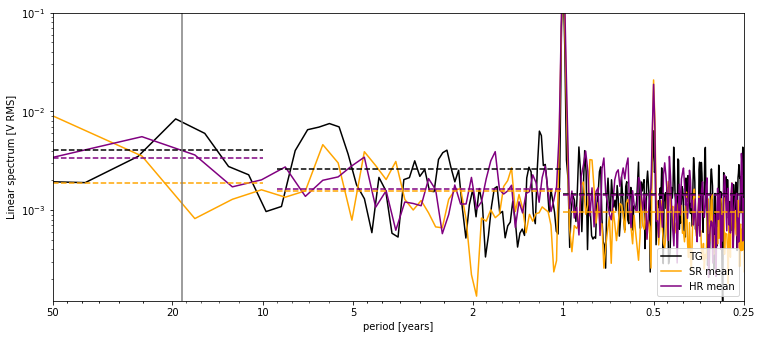

In [13]:
# Now, we will create the means of the spectra of the ensemble members:
xticks = [50,20,10,5,2,1,.5,.25]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)

# Setting the figure lay-out:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0.1,0.1,.8,.8])
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim((1/50,1/24))
ax.set_ylim((1.2e-4,1e-1))

# Plotting the means of the members of SR and HR and the unchanges TG:
tgs, Pxx_spec = signal.welch(dgdt, fs=12, nperseg=2*468,  detrend = False, return_onesided=True)
plt.plot(tgs, Pxx_spec, label='TG', color='black') #TG spectra
s = (s1spec+s2spec+s3spec)/3
plt.plot(s1, s, label= 'SR mean', color='orange') #means of SR spectra
h = (h1spec+h2spec+h3spec)/3
plt.plot(s1, h, label = 'HR mean', color='purple') #means of HR spectra

# Next, we calculate the weighted means of the different spectra over the three time periods,
# using the function defined in the cell above:

# Multi-decadal:
period1, period2 = 50, 10
mu_tg = power_mean(Pxx_spec, tgs, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_tg], color='black', ls=('--'))
mu_s = power_mean(s, s1, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_s], color='orange', ls=('--'))
mu_h = power_mean(h, s1, period1=50, period2=10)
plt.plot([1/period1,1/period2], 2*[mu_h], color='purple', ls=('--'))

# Inter-annual:
p1, p2 = 9, 1
mu_tga = power_mean(Pxx_spec, tgs, period1=9, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_tga], color='black', ls=('--'))
mu_sa = power_mean(s, s1, period1=5, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_sa], color='orange', ls=('--'))
mu_ha = power_mean(h, s1, period1=5, period2=1)
plt.plot([1/p1,1/p2], 2*[mu_ha], color='purple', ls=('--'))

# Sub-annual:
pd1, pd2 = 1, 0.25
mu_tga = power_mean(Pxx_spec, tgs, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_tga], color='black', ls=('--'))
mu_sa = power_mean(s, s1, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_sa], color='orange', ls=('--'))
mu_ha = power_mean(h, s1, period1=1, period2=.25)
plt.plot([1/pd1,1/pd2], 2*[mu_ha], color='purple', ls=('--'))

# Adding more figure lay-out:
plt.ylabel('Linear spectrum [V RMS]')
plt.axvline(1/18.6, c='C7')
plt.legend(loc=4)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)
ax.set_xlabel('period [years]')
fig.align_ylabels()

#plt.savefig('../results/welchmeans.jpg', dpi=300, bbox_inches='tight')

### Maps North Sea overview

To gain a better insight in the processes in the DSL changes in the specific location, I will create maps of the DSL of the whole North Sea of the historic plus future runs over three different time periods. I will take the mean of the model ensemble members (’r1i1p2f1’ ’r2i1p2f1’ and ’r3i1p2f1’) and for this first overview, the data from the historic and future run are selected. The left maps show the mean
DSL for the period 2000-2020 in blue. The mean of all the yearly means in this period is selected to create
the map. For the middle maps, I subtracted the data from the
first map, so the mean DSL between 2000-2020, from the mean DSL in the period between 2030-2050. This
gives an insight in the change in DSL in the middle of the century. The last maps on the right also show the change in DSL, but then for
the end of the century, so 2080-2100.
This will be done for the HR, SR and also for the difference between them: HR-SR. This difference map first needs regridded data of the SR to a high resolution to subtract the cells.

#### Mean members DSL

In [14]:
# First, we need to create the map of the differences
dar = xr.open_dataarray(f'../data/regridded/zos_NorthSea_SR_regridded.nc')
dah = xr.open_dataarray(f'../data/zos_NorthSea_HR.nc')

difference_map = dah - dar

# We convert this map to the same format as the SR and HR maps, so that it can easily be included in the figure:
#difference_map.to_netcdf('../data/zos_NorthSea_zos_HR-SR.nc') 

C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, plea

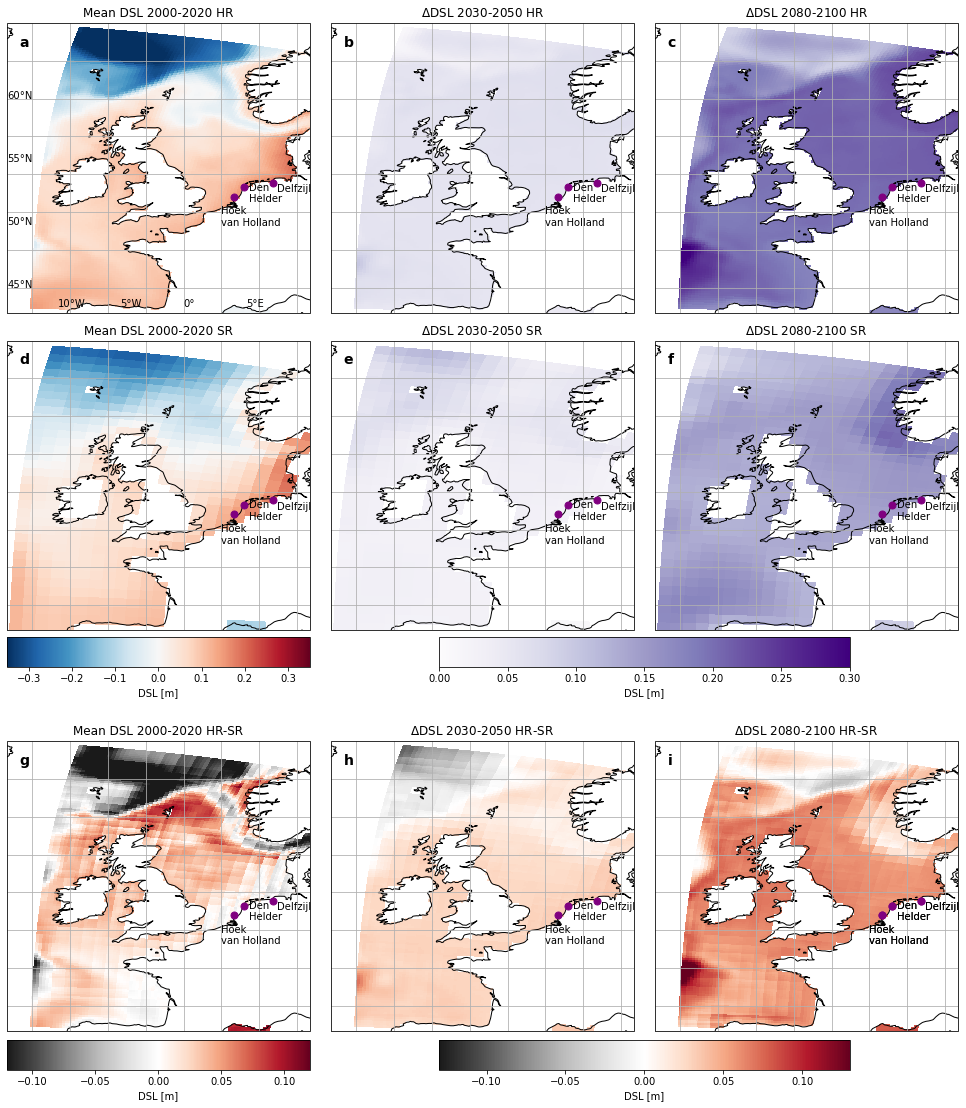

In [15]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    # member average
    da = da.mean('member')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields for the different columns:
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020, with regard to the contemporary mean instead of the global mean DSL
    
    for j in range(3):
        delta = r'$\Delta$'

        # The first maps, which are mean DSL 2000-2020:
        if j==0: # So the first column
            field = hist_
           
            if i==0: # First row
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
                # In the first map, we add some coordinates for reference:
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.PlateCarree())

            if i==1: # Second row
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2: # Third row
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            
           
        # Then the second column, which is the change 2030-2050 with regard to mean DSL present-day
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res}'
            field = midc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==1: # Row 2
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==2: # Row 3
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())  
       
        # Then the third column, which is the change 2080-2100 with regard to mean DSL present-day
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res}'
            field = endc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1: # Row 2
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==2: # Row 3
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
        
        # Then, we mark the locations along the coast:         
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
        
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        # Now we add the colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
                
#plt.savefig('../results/hist+futzosmap.jpg', dpi=300, bbox_inches='tight')

#### Member 1 DSL

C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, plea

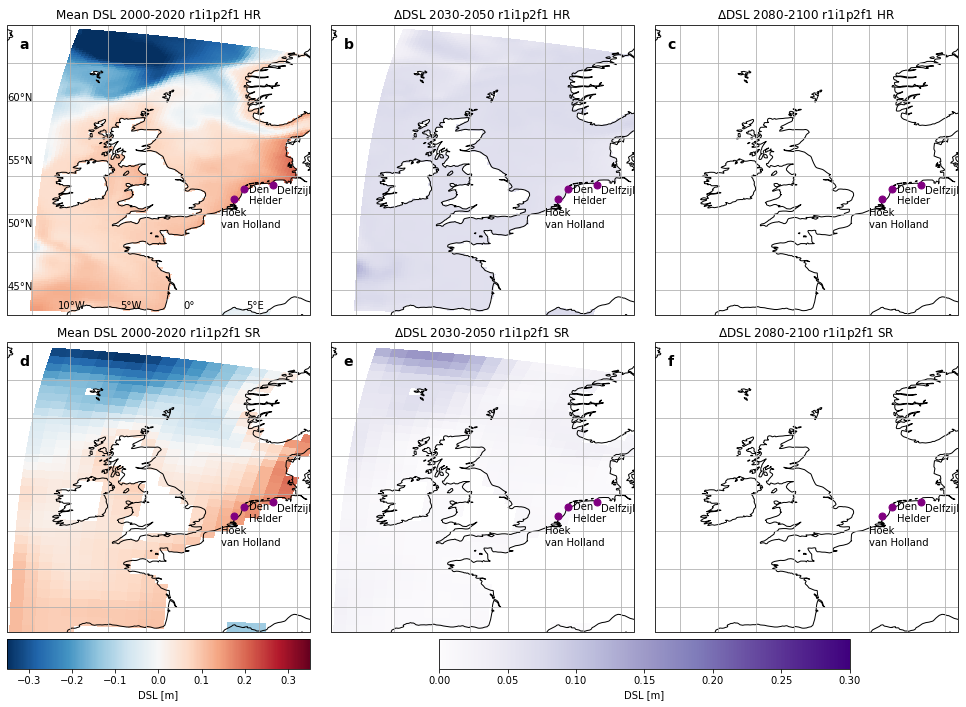

In [16]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    # selecting member:
    da = da.sel(member='r1i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields for the different columns:
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020, with regard to the contemporary mean instead of the global mean DSL
    
    for j in range(3):
        delta = r'$\Delta$'

        # The first maps, which are mean DSL 2000-2020:
        if j==0: # So the first column
            field = hist_
           
            if i==0: # First row
                title = f'Mean DSL 2000-2020 r1i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
                # In the first map, we add some coordinates for reference:
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.PlateCarree())

            if i==1: # Second row
                title = f'Mean DSL 2000-2020 r1i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
        # Then the second column, which is the change 2030-2050 with regard to mean DSL present-day
        elif j==1:
            title = f'{delta}DSL 2030-2050 r1i1p2f1 {res}'
            field = midc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==1: # Row 2
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree()) 
       
        # Then the third column, which is the change 2080-2100 with regard to mean DSL present-day
        elif j==2:
            title = f'{delta}DSL 2080-2100 r1i1p2f1 {res}'
            field = endc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1: # Row 2
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
        
        # Then, we mark the locations along the coast:         
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
        
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        # Now we add the colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
                
#plt.savefig('../results/hist+futzosmap1.jpg', dpi=300, bbox_inches='tight')

#### Member 2 DSL

C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, plea

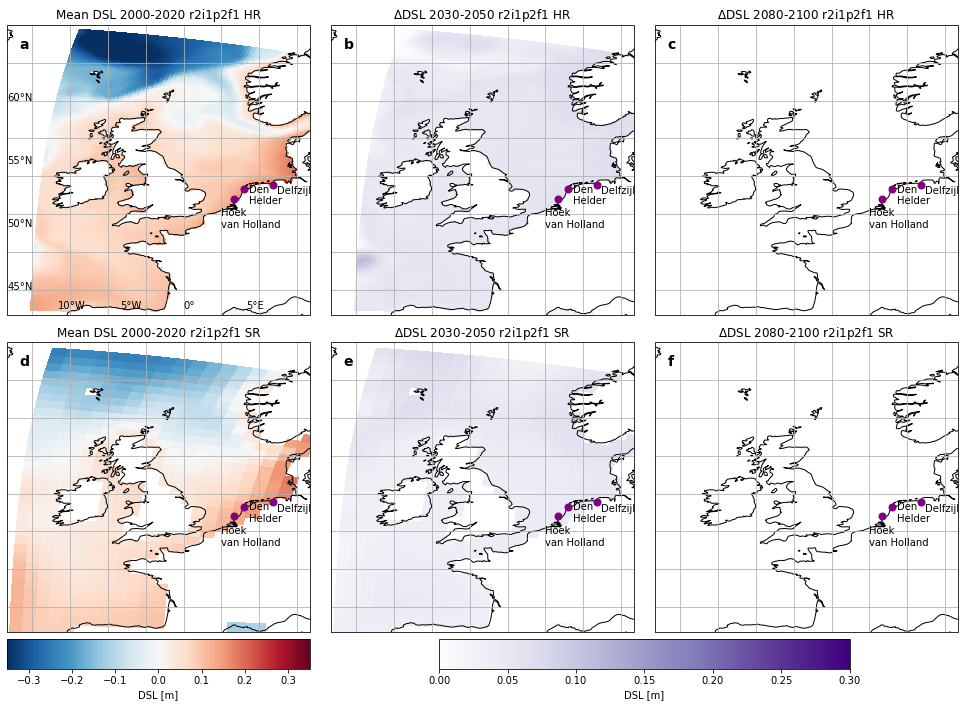

In [17]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    # selecting member:
    da = da.sel(member='r2i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields for the different columns:
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020, with regard to the contemporary mean instead of the global mean DSL
    
    for j in range(3):
        delta = r'$\Delta$'

        # The first maps, which are mean DSL 2000-2020:
        if j==0: # So the first column
            field = hist_
           
            if i==0: # First row
                title = f'Mean DSL 2000-2020 r2i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
                # In the first map, we add some coordinates for reference:
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.PlateCarree())

            if i==1: # Second row
                title = f'Mean DSL 2000-2020 r2i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
        # Then the second column, which is the change 2030-2050 with regard to mean DSL present-day
        elif j==1:
            title = f'{delta}DSL 2030-2050 r2i1p2f1 {res}'
            field = midc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==1: # Row 2
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree()) 
       
        # Then the third column, which is the change 2080-2100 with regard to mean DSL present-day
        elif j==2:
            title = f'{delta}DSL 2080-2100 r2i1p2f1 {res}'
            field = endc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1: # Row 2
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
        
        # Then, we mark the locations along the coast:         
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
        
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        # Now we add the colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
                
#plt.savefig('../results/hist+futzosmap2.jpg', dpi=300, bbox_inches='tight')

#### Member 3 DSL

C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
C:\Anaconda\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, plea

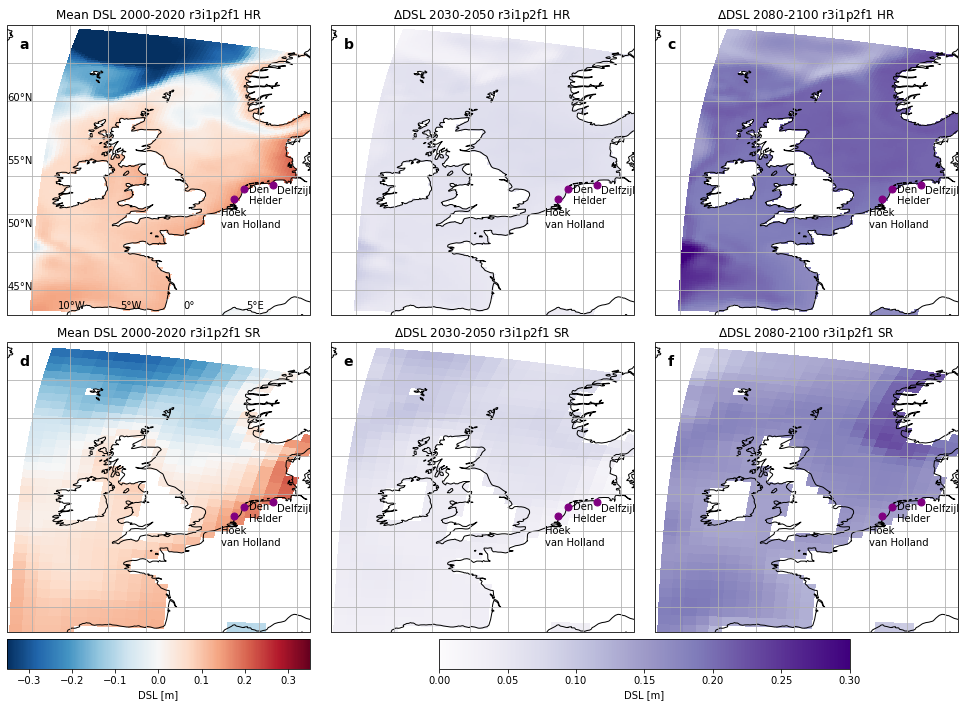

In [18]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    # selecting member:
    da = da.sel(member='r3i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields for the different columns:
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020, with regard to the contemporary mean instead of the global mean DSL
    
    for j in range(3):
        delta = r'$\Delta$'

        # The first maps, which are mean DSL 2000-2020:
        if j==0: # So the first column
            field = hist_
           
            if i==0: # First row
                title = f'Mean DSL 2000-2020 r3i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
                # In the first map, we add some coordinates for reference:
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.PlateCarree())

            if i==1: # Second row
                title = f'Mean DSL 2000-2020 r3i1p2f1 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
        # Then the second column, which is the change 2030-2050 with regard to mean DSL present-day
        elif j==1:
            title = f'{delta}DSL 2030-2050 r3i1p2f1 {res}'
            field = midc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==1: # Row 2
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree()) 
       
        # Then the third column, which is the change 2080-2100 with regard to mean DSL present-day
        elif j==2:
            title = f'{delta}DSL 2080-2100 r3i1p2f1 {res}'
            field = endc - hist
            
            if i==0: # Row 1
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1: # Row 2
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .3
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
        
        # Then, we mark the locations along the coast:         
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
        
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        # Now we add the colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
                
#plt.savefig('../results/hist+futzosmap3.jpg', dpi=300, bbox_inches='tight')

#### Mean members wind

To find an explanation for the patterns and differences, I created
the same maps for the wind over the North Sea. The setup is similar to the DSL maps, only now without the difference between the two resolutions.

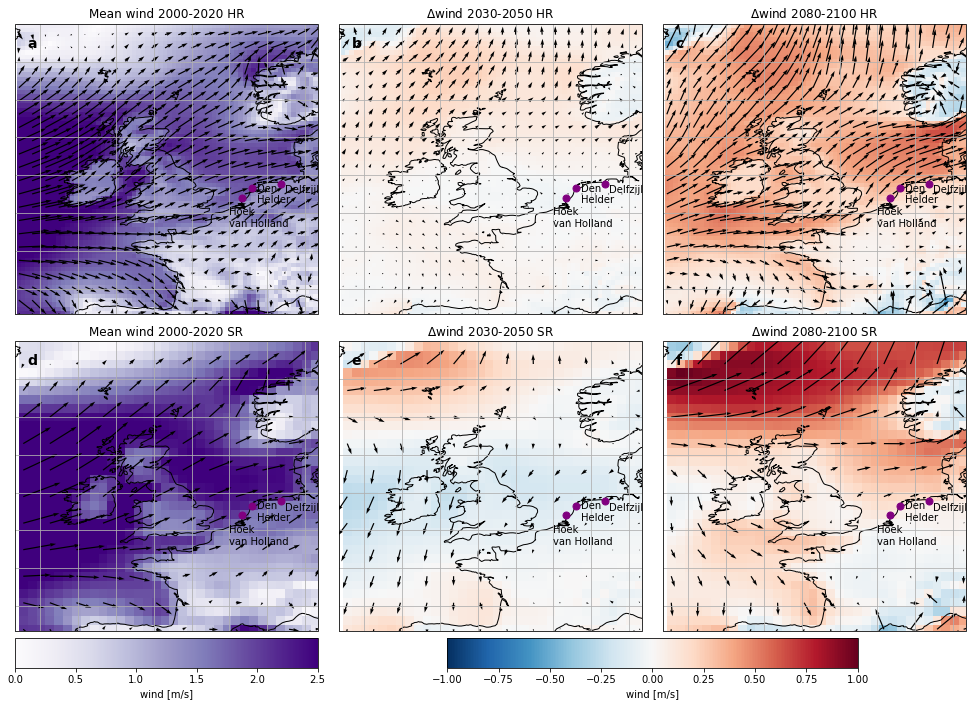

In [19]:
f = plt.figure(figsize=(15, 10.5))
for i, res in enumerate(['HR','SR']):
    
    # load HR/SR data for u and v:
    u = xr.open_dataarray(f'../data/wind/uas_NorthSea_{res}.nc') 
    v = xr.open_dataarray(f'../data/wind/vas_NorthSea_{res}.nc')
    # member average
    u = u.mean('member')
    v = v.mean('member')
    # monthly -> yearly
    u = u.groupby(u.time.dt.year).mean()
    v = v.groupby(v.time.dt.year).mean()
    
    dhfu = u.sel(exp='hist+future')
    dhfv = v.sel(exp='hist+future')
   
    # final fields
    histu = dhfu.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    histv = dhfv.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    hist = np.sqrt(histu.values**2+histv.values**2)
    
    midcu = dhfu.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midcv = dhfv.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midc = np.sqrt(midcu.values**2+midcv.values**2)
    
    endcu = dhfu.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endcv = dhfv.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endc = np.sqrt(endcu.values**2+endcv.values**2)
    
    for j in range(3):
        # mark the locations and define delta
        ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        delta = r'$\Delta$'
        
        # First column is mean winds present-day:
        if j==0:            
            title = f'Mean wind 2000-2020 {res}'
            field = hist
            minv, maxv = 0, 2.5
            if i==0: 
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)
            if i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)    
        
        # Second column is mid-century:
        elif j==1:
            field = midc - hist
            title = f'{delta}wind 2030-2050 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                
         # Third column is end-century:
        elif j==2:
            field = endc - hist
            title = f'{delta}wind 2080-2100 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
       
        # Adding colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
       
        # And some general lay-out:
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.set_title(title)   
        ax.coastlines()
        ax.gridlines()
        
#plt.savefig('../results/hist+futwind.jpg', dpi=300, bbox_inches='tight')

#### Member 1 wind

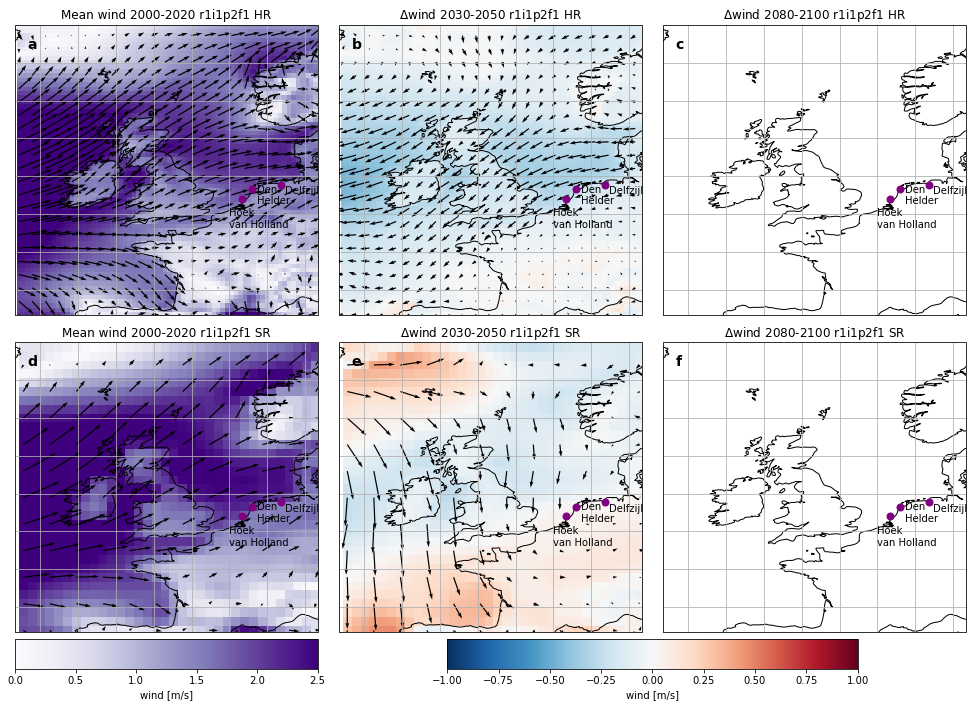

In [20]:
f = plt.figure(figsize=(15, 10.5))
for i, res in enumerate(['HR','SR']):
    
    # load HR/SR data for u and v:
    u = xr.open_dataarray(f'../data/wind/uas_NorthSea_{res}.nc') 
    v = xr.open_dataarray(f'../data/wind/vas_NorthSea_{res}.nc')
    # member average
    u = u.sel(member='r1i1p2f1')
    v = v.sel(member='r1i1p2f1')
    # monthly -> yearly
    u = u.groupby(u.time.dt.year).mean()
    v = v.groupby(v.time.dt.year).mean()
    
    dhfu = u.sel(exp='hist+future')
    dhfv = v.sel(exp='hist+future')
   
    # final fields
    histu = dhfu.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    histv = dhfv.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    hist = np.sqrt(histu.values**2+histv.values**2)
    
    midcu = dhfu.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midcv = dhfv.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midc = np.sqrt(midcu.values**2+midcv.values**2)
    
    endcu = dhfu.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endcv = dhfv.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endc = np.sqrt(endcu.values**2+endcv.values**2)
    
    for j in range(3):
        # mark the locations and define delta
        ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        delta = r'$\Delta$'
        
        # First column is mean winds present-day:
        if j==0:            
            title = f'Mean wind 2000-2020 r1i1p2f1 {res}'
            field = hist
            minv, maxv = 0, 2.5
            if i==0: 
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)
            if i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)    
        
        # Second column is mid-century:
        elif j==1:
            field = midc - hist
            title = f'{delta}wind 2030-2050 r1i1p2f1 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                
         # Third column is end-century:
        elif j==2:
            field = endc - hist
            title = f'{delta}wind 2080-2100 r1i1p2f1 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
       
        # Adding colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
       
        # And some general lay-out:
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.set_title(title)   
        ax.coastlines()
        ax.gridlines()
        
#plt.savefig('../results/hist+futwind1.jpg', dpi=300, bbox_inches='tight')

#### Member 2 wind

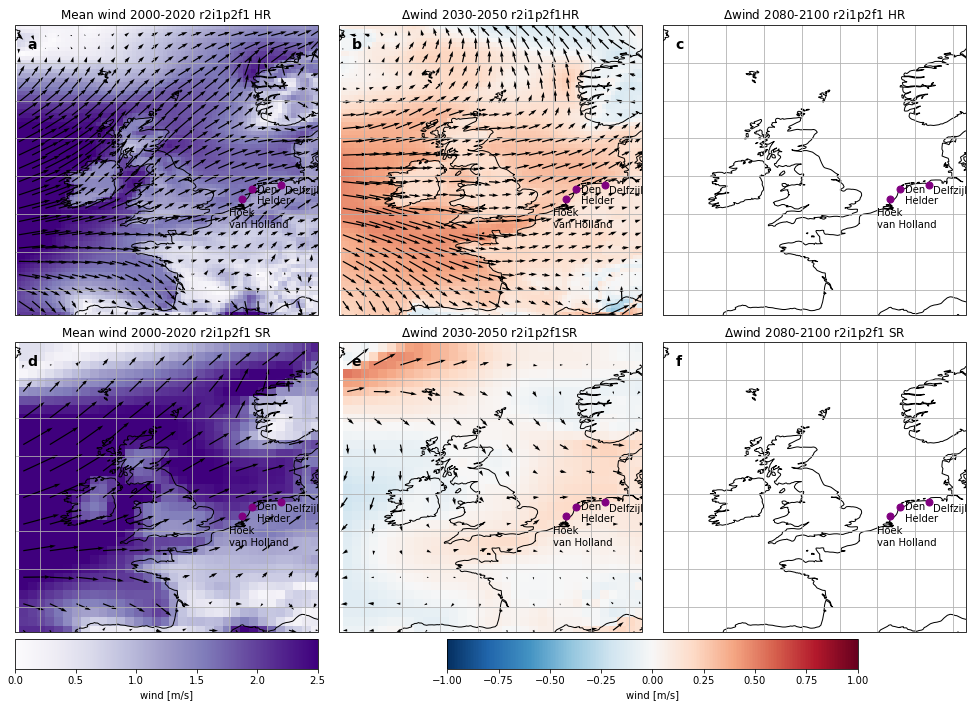

In [21]:
f = plt.figure(figsize=(15, 10.5))
for i, res in enumerate(['HR','SR']):
    
    # load HR/SR data for u and v:
    u = xr.open_dataarray(f'../data/wind/uas_NorthSea_{res}.nc') 
    v = xr.open_dataarray(f'../data/wind/vas_NorthSea_{res}.nc')
    # member average
    u = u.sel(member='r2i1p2f1')
    v = v.sel(member='r2i1p2f1')
    # monthly -> yearly
    u = u.groupby(u.time.dt.year).mean()
    v = v.groupby(v.time.dt.year).mean()
    
    dhfu = u.sel(exp='hist+future')
    dhfv = v.sel(exp='hist+future')
   
    # final fields
    histu = dhfu.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    histv = dhfv.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    hist = np.sqrt(histu.values**2+histv.values**2)
    
    midcu = dhfu.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midcv = dhfv.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midc = np.sqrt(midcu.values**2+midcv.values**2)
    
    endcu = dhfu.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endcv = dhfv.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endc = np.sqrt(endcu.values**2+endcv.values**2)
    
    for j in range(3):
        # mark the locations and define delta
        ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        delta = r'$\Delta$'
        
        # First column is mean winds present-day:
        if j==0:            
            title = f'Mean wind 2000-2020 r2i1p2f1 {res}'
            field = hist
            minv, maxv = 0, 2.5
            if i==0: 
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)
            if i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)    
        
        # Second column is mid-century:
        elif j==1:
            field = midc - hist
            title = f'{delta}wind 2030-2050 r2i1p2f1{res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                
         # Third column is end-century:
        elif j==2:
            field = endc - hist
            title = f'{delta}wind 2080-2100 r2i1p2f1 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
       
        # Adding colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
       
        # And some general lay-out:
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.set_title(title)   
        ax.coastlines()
        ax.gridlines()
        
#plt.savefig('../results/hist+futwind2.jpg', dpi=300, bbox_inches='tight')

#### Member 3 wind

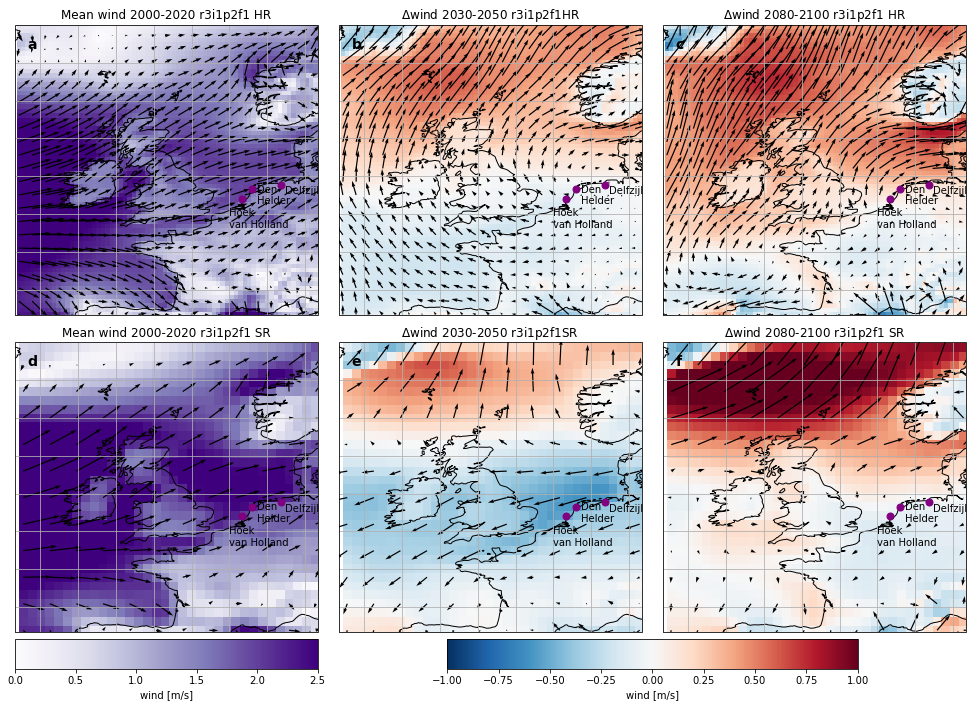

In [22]:
f = plt.figure(figsize=(15, 10.5))
for i, res in enumerate(['HR','SR']):
    
    # load HR/SR data for u and v:
    u = xr.open_dataarray(f'../data/wind/uas_NorthSea_{res}.nc') 
    v = xr.open_dataarray(f'../data/wind/vas_NorthSea_{res}.nc')
    # member average
    u = u.sel(member='r3i1p2f1')
    v = v.sel(member='r3i1p2f1')
    # monthly -> yearly
    u = u.groupby(u.time.dt.year).mean()
    v = v.groupby(v.time.dt.year).mean()
    
    dhfu = u.sel(exp='hist+future')
    dhfv = v.sel(exp='hist+future')
   
    # final fields
    histu = dhfu.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    histv = dhfv.isel({'year':slice( 50, 70)}).mean('year')   # 2000-2020
    hist = np.sqrt(histu.values**2+histv.values**2)
    
    midcu = dhfu.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midcv = dhfv.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    midc = np.sqrt(midcu.values**2+midcv.values**2)
    
    endcu = dhfu.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endcv = dhfv.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    endc = np.sqrt(endcu.values**2+endcv.values**2)
    
    for j in range(3):
        # mark the locations and define delta
        ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        delta = r'$\Delta$'
        
        # First column is mean winds present-day:
        if j==0:            
            title = f'Mean wind 2000-2020 r3i1p2f1 {res}'
            field = hist
            minv, maxv = 0, 2.5
            if i==0: 
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)
            if i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'Purples'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(histu).values[::3,::3],(histv).values[::3,::3], scale=30, width=0.004)    
        
        # Second column is mid-century:
        elif j==1:
            field = midc - hist
            title = f'{delta}wind 2030-2050 r3i1p2f1{res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(midcu-histu).values[::3,::3],(midcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                
         # Third column is end-century:
        elif j==2:
            field = endc - hist
            title = f'{delta}wind 2080-2100 r3i1p2f1 {res}'
            minv, maxv = -1, 1
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                im = ax.pcolormesh(u.lon, u.lat, 
                            field,
                          vmin=minv, vmax=maxv, cmap=cmap)
                plt.quiver(u.lon[::3],u.lat[::3],(endcu-histu).values[::3,::3],(endcv-histv).values[::3,::3], scale=6, width=0.004)
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
       
        # Adding colorbars:
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'wind [m/s]')
       
        # And some general lay-out:
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.set_title(title)   
        ax.coastlines()
        ax.gridlines()
        
#plt.savefig('../results/hist+futwind3.jpg', dpi=300, bbox_inches='tight')